In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

Only blocks and matrix is needed to initialize a ``City`` model

In [2]:
from masterplan_tools.models import City 

aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

city_model = City(accessibility_matrix, aggregated_blocks)

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


``Block`` can be accessed via ``id``

``ServiceType`` entity can be obtained the same way by ``name``

In [3]:
block_123 = city_model[123]
service_type_schools = city_model['schools']

We can calculate, how much the service should supply to satisfy population needs

In [4]:
city_model['schools'].calculate_in_need(110)

14

``ServiceType`` is an entity, which describes certain service types available for the city, but doesn't provide geospatial services information (e.g. schools locations)

In [5]:
city_model.service_types

[ServiceType(name='kindergartens', accessibility=10, demand=61),
 ServiceType(name='schools', accessibility=15, demand=120),
 ServiceType(name='recreational_areas', accessibility=15, demand=6000),
 ServiceType(name='hospitals', accessibility=60, demand=9),
 ServiceType(name='pharmacies', accessibility=10, demand=50),
 ServiceType(name='policlinics', accessibility=15, demand=27)]

In [6]:
city_model.add_service_type('bakeries', accessibility=30, demand=100)
city_model['bakeries']

ServiceType(name='bakeries', accessibility=30, demand=100)

But now we can aggregate the info directly to the ``Block`` of the ``City`` from the ``GeoDataFrame``

In [7]:
bakeries = gpd.read_file(os.path.join(example_data_path, "bakeries.geojson")).to_crs(local_crs)
city_model.update_service_type_layer(service_type=city_model['bakeries'], gdf=bakeries)
print('Block bakeries:', city_model[16]['bakeries'])

Block bakeries: {'capacity': 0, 'demand': 395}


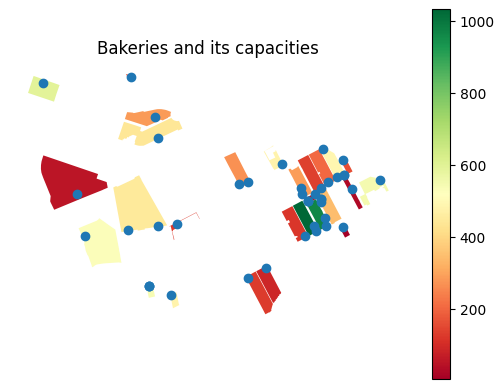

In [8]:
import matplotlib.pyplot as plt

bakeries_blocks = list(filter(lambda x : x['bakeries']['capacity'] > 0, city_model.blocks))
gdf = gpd.GeoDataFrame(map(lambda block : {"id":block.id, "capacity": block['bakeries']['capacity'], "geometry": block.geometry}, bakeries_blocks))
fig, ax = plt.subplots()
ax.set_axis_off()
ax.set_title('Bakeries and its capacities')
gdf.plot(ax=ax, alpha=1, column='capacity', legend=True, cmap='RdYlGn')
bakeries.plot(ax=ax)
plt.show()

In [16]:
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet")).to_crs(local_crs)
city_model.update_service_type_layer(service_type=city_model['kindergartens'], gdf=kindergartens)
service_type = 'kindergartens'

In [17]:
graph = city_model.graph
demand_blocks = list(filter(lambda b : b[service_type]['demand'] > 0, graph.nodes))
capacity_blocks = list(filter(lambda b : b[service_type]['capacity'] > 0, graph.nodes))
for demand_block in demand_blocks:
  demand = demand_block[service_type]['demand']
  graph.nodes[demand_block]['demand'] = demand
  graph.nodes[demand_block]['demand_left'] = demand
  graph.nodes[demand_block]['demand_within'] = 0
  graph.nodes[demand_block]['demand_without'] = 0
for capacity_block in capacity_blocks:
  capacity = capacity_block[service_type]['capacity']
  graph.nodes[capacity_block]['capacity'] = capacity
  graph.nodes[capacity_block]['capacity_left'] = capacity
result_blocks = demand_blocks.copy()

In [18]:
def get_sorted_neighbors(block):
  return sorted(capacity_blocks, key=lambda b : graph[block][b]['weight'])

In [19]:
sum = 0
while len(demand_blocks)>0 and len(capacity_blocks)>0:
  for demand_block in demand_blocks:
    sum+=1
    neighbors = get_sorted_neighbors(demand_block)
    if len(neighbors) == 0 : break
    capacity_block = neighbors[0]
    graph.nodes[demand_block]['demand_left'] -= 1
    if graph[demand_block][capacity_block]['weight'] <= city_model[service_type].accessibility : graph.nodes[demand_block]['demand_within'] += 1
    else : graph.nodes[demand_block]['demand_without'] += 1
    if graph.nodes[demand_block]['demand_left'] == 0 : demand_blocks.remove(demand_block)
    graph.nodes[capacity_block]['capacity_left'] -= 1
    if graph.nodes[capacity_block]['capacity_left'] == 0 : capacity_blocks.remove(capacity_block)
print("number of iterations:", sum)

number of iterations: 10460


In [20]:
def result_to_gdf(result_blocks):
  result = []
  for block in result_blocks:
    result.append({'id': block.id, "geometry": block.geometry, "provision": graph.nodes[block]['demand_within'] / graph.nodes[block]['demand']})
  return gpd.GeoDataFrame(result)

<Axes: >

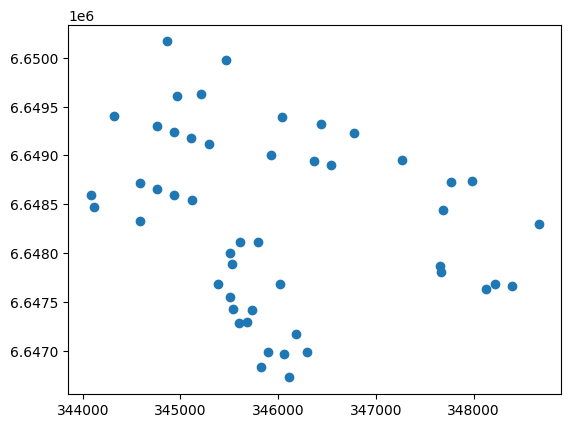

In [28]:
kindergartens.plot()

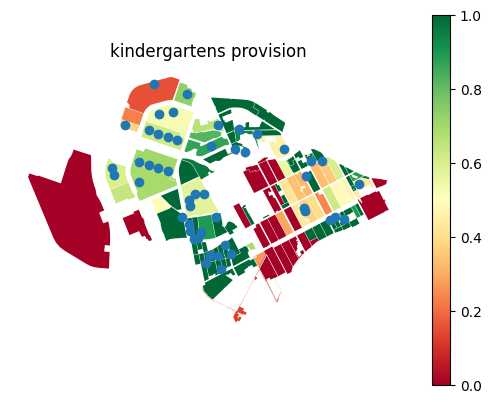

In [33]:
gdf = result_to_gdf(result_blocks).set_crs(local_crs)
fig, ax = plt.subplots()
ax.set_axis_off()
ax.set_title(f'{service_type} provision')
gdf.plot(ax=ax, alpha=1, column='provision', legend=True, cmap='RdYlGn')
kindergartens.plot(ax=ax, alpha=1)
plt.show()